In [203]:
%%writefile src/myProject.py
#coding: utf-8
from pymongo import MongoClient
import mylib
import os
import sys
import requests
import findspark
import pyspark

client = MongoClient('localhost:27017')
db = client.bigData

os.environ["SPARK_HOME"]='C:\Users\Code\s-201111265\spark-2.0.0-bin-hadoop2.6'
findspark.init(os.environ["SPARK_HOME"])
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder.master("local")\
    .appName("myApp").config("spark.sql.warehouse.dir", os.path.join(os.environ['SPARK_HOME'], 'data', 'data_warehouse'))\
    .getOrCreate()

# 코스피 지수와 날짜를 네이버 금융 메뉴에서 파싱해 옵니다. 
# 날짜별로, 전 날짜와 비교하여 상승했으면 1, 하강했으면 0이라는 값을 추가하고 
# (날짜, 상승/하강)을  'data', 'kospi.txt'에 저장하고 몽고DB는 bigData db의 kospi라는 document에 저장합니다.
def save_kospi_data():
    import urllib
    
    count=22 #마지막 거래일로부터 몇 거래일의 주가지수를 가져올지 입력
    url="http://fchart.stock.naver.com/sise.nhn?symbol=KOSPI&timeframe=day&count=%d&requestType=0"%(count)
    urltext=urllib.urlopen(url).read().decode('latin-1')

    KOSPI=[]
    stocklist=urltext.split("\"")
    stocklist_selection=stocklist[17:]

    i=0
    while i<=(len(stocklist_selection)-1):
        KOSPI.append(stocklist_selection[i])
        i=i+2

    KOSPI=str(KOSPI).split("|")
    KOSPI[0]=KOSPI[0][2:]
    KOSPI[len(KOSPI)-1]=KOSPI[len(KOSPI)-1][:7]
    #중간에 수치에 붙어있는 군더더기 제거

    date=[KOSPI[0]]
    price=[]
    volumn=[]

    j=5
    while j<=(len(KOSPI)-5):
        date.append(KOSPI[j][10:])
        volumn.append(KOSPI[j][:7])
        j=j+5
    volumn.append(KOSPI[len(KOSPI)-1])

    r=0
    while r<=(len(volumn)-2):
        volumn[r]=volumn[r][:(len(volumn[r])-1)]
        r=r+1
    #거래량 끝에 붙어있는 ' 제거
    k=4
    while k<=(len(KOSPI)-1):
        price.append(KOSPI[k])
        k=k+5

    kospi_dict = dict()

    for i in range(len(date)):
        temp = float(price[i])
        temp_date = int(date[i][1:len(date[i])])
        kospi_dict[temp_date] = temp

    keys = kospi_dict.keys()   

    for i in range(len(kospi_dict)-1, 0, -1):
        if(kospi_dict[keys[i]] > kospi_dict[keys[i-1]]):
            kospi_dict[keys[i]] = 1 #1이면 상승
        else:
            kospi_dict[keys[i]] = 0 #0이면 하락

    kospi_dict = kospi_dict.items()

    big_str = ""
    
    for i in range(1, len(kospi_dict)):
        big_str = big_str + str(kospi_dict[i][0]) + ' '
        big_str = big_str + str(kospi_dict[i][1]) + '\n'
    
    f = open(os.path.join('data', 'kospi.txt'),'w')
    f.write(big_str)
    f.close()

    sorted_kospi_list = list()
    sorted_kospi_list.append(big_str)
    #db.kospiData.insert_one({
    #   "kospi": sorted_kospi_list
    #})

# 검색어로 네이버 블로그의 제목, 포스팅 날짜를 가져옵니다. 오픈 api를 사용합니다.
# 날짜별로, 전 날짜와 비교하여 상승했으면 1, 하강했으면 0이라는 값을 추가하고 
# (날짜, 제목)을  'data', 'blog.txt'에 저장하고 몽고DB는 bigData db의 blogData라는 document에 저장합니다.
def save_blog_data(keyword):
    #블로그
    key_path = os.path.join('src', 'key.properties')
    keys = mylib.getKey(key_path)

    info = keys['naver'].split(',')

    client_id = info[0]
    client_secret = info[1]

    #https://openapi.naver.com/v1/search/news.json - 뉴스
    #https://openapi.naver.com/v1/search/kin.json - 지식IN (날짜 없음)
    #https://openapi.naver.com/v1/search/cafearticle.json - 카페글 (날짜 없음)
    #https://openapi.naver.com/v1/search/webkr.json - 웹문서
    
    start = 1
    client = MongoClient('localhost:27017')
    db = client.bigData
    count = 0
    
    big_str = ''
    while(start < 1000):
        # json 결과, start -> 시작위치(최대 1000), dispaly -> 출력갯수(최대 100)
        blog_str = ''
        url = "https://openapi.naver.com/v1/search/blog?query=" + keyword + '&display=50' + '&start=' + str(start)
        start = start + 100
        headers_info = {"X-Naver-Client-Id": client_id,  "X-Naver-Client-Secret":client_secret}
        response = requests.get(url, headers=headers_info)
        result_json = response.json()
        for ele in result_json['items']:
            blog_str = blog_str + ele['postdate'] +  ele['title'] + '\n'
        big_str = big_str + blog_str + '\n'
        count = count+1
    big_list = []
    big_list.append(big_str)
    #db.blogData.insert_one({
    #    "entire": big_list
    #})
    
    f = open(os.path.join('data', 'blog.txt'), 'w')
    f.write(big_str.encode('utf8'))
    f.close()
    

def sub_str(str):
    return str[8:]

def exetract(str):
    boolean = str.find(unicode('<b>'))
    if(boolean == -1):
        boolean2 = str.find('2017')
        if(boolean2 == -1):
            boolean3 = str.find('2016')
            if(boolean3 == -1):
                return str
            else:
                return "-1"
        else:
            return "-1"
    else:
        return "-1"

# stop_word 라는 한글 불용어 리스트를 필터에 사용하며, blog.txt에서 제목만 가지고 제일 많이 사용한 단어
# 20개를 추출해냅니다.
def find_most_used_word():
    stop_word = list()
    f = open(os.path.join('data', 'stopwords.txt'))
    entire_word = f.readlines()
    for ele in entire_word:
        word = ele.strip() 
        stop_word.append(word)
    f.close()
    stop_word.append(u'및')
    stop_word.append(u'-')

    rdd = spark.sparkContext.textFile(os.path.join('data','blog.txt'))
    lines = rdd.flatMap(lambda x:x.split('\n')).map(sub_str).flatMap(lambda x:x.split())\
            .map(exetract).filter(lambda x : x not in stop_word).map(lambda x:(x,1))\
            .reduceByKey(lambda x,y: x+y).map(lambda x:(x[1],x[0])).sortByKey(False)

    most_word_list = list()
    for element in lines.take(20):
        if element[1] == '-1':
            continue
        else:
            most_word_list.append(element[1])
    
    return most_word_list

def sub_split(str):
    back = sub_str(str)+" "
    front = str[:8]
    temp = list()
    temp.append(front)
    temp.append(back)
    return tuple(temp)

# blog.txt와 kospi.txt의 날짜를 비교하여 같은 날짜면 새로운 리스트에 추가하는 식으로 진행하고,
# 합병한 리스트를 반환합니다.

def reduce_and_merge():
    rdd = spark.sparkContext.textFile(os.path.join('data','blog.txt'))
    lines = rdd.flatMap(lambda x:x.split('\n')).map(sub_split)\
        .reduceByKey(lambda x, y: x+y).sortByKey(False)
    lines_list = list()
    lines_list.append(lines.collect())
    rdd2 = spark.sparkContext.textFile(os.path.join('data','kospi.txt'))
    lines2 = rdd2.flatMap(lambda x:x.split('\n')).map(lambda x:x.split())
    lines_list2 = list()
    lines_list2.append(lines2.collect())
    for i in range(len(lines_list[0])):
    for j in range(len(lines_list2[0])):
        if(lines_list[0][i][0] == lines_list2[0][j][0]):
            lines_list2[0][j][1] = lines_list2[0][j][1] + '|' + lines_list[0][i][1]
            break
    return lines_list2
    
    
## 날짜별로 합병한 데이터를 상승/하강 별로 나눕니다.    
def upper_data(my_list):
    upper = list()
    for i in range(len(my_list[0])):
        temp = my_list[0][i][1].split('|')
        if(temp[0] == '1'):
            upper.append(my_list[0][i])
            
def lower_data(my_list):
    lower = list()
    for i in range(len(my_list[0])):
        temp = my_list[0][i][1].split('|')
        if(temp[0] == '0'):
            upper.append(my_list[0][i])

# 상승 / 하강 별로, 전에 뽑아두었던 가장 많이 쓰이는 
#단어가 몇번 사용되었는지 계산
def freq_calculate(my_list): 
    most = find_most_used_word()
    frequency = dict()

    for i in range(len(my_list)):
        temp = list()
        check_list = list()
        temp = my_list[i][1].split('|')
        check_list = temp[1].split()
        for ele_j in check_list:
            for ele_k in most:
                if(ele_j == ele_k):
                    if ele_k in frequency:
                        frequency[ele_k] += 1
                    else:
                        frequency[ele_k] = 1
    return frequency

# 위에서 구한 상승과 하강 데이터의 출현 빈도수, 가장 많이 출현한 단어 20개 
# 데이터를 인자로 받아서 dataFrame 생성
def make_dataFrame(my_dict1, my_dict2, most_list):
    fre_keys = my_dict1.keys()
    index_list = list()

    for i in range(len(most_list)):
        for j in range(len(fre_keys)):
            if most_list[i] == fre_keys[j]:
                index_list.append(i)
            
    fre_keys2 = my_dict2.keys()
    index_list2 = list()

    for i in range(len(most_list)):
        for j in range(len(fre_keys2)):
            if most_list[i] == fre_keys2[j]:
                index_list2.append(i)

    #print index_list
    #print index_list2

    from pyspark.mllib.regression import LabeledPoint
    from pyspark.mllib.linalg import Vectors

    tmp_dict = dict()
    for i in range(len(index_list)):
        tmp_dict[index_list[i]] = my_dict1[most_list[index_list[i]]]

    tmp_dict2 = dict()
    for i in range(len(index_list2)):
        tmp_dict2[index_list2[i]] = my_dict2[most_list[index_list2[i]]]

    p = [
        LabeledPoint(1, Vectors.sparse(20, tmp_dict )),
        LabeledPoint(0, Vectors.sparse(20, tmp_dict2 ))
    ]

    trainDf = spark.createDataFrame(p)
    trainDf.show()
    
def draw_graph(freq_diction):
    import matplotlib.pyplot as plt
    count = freq_diction.values()
    word = freq_diction.keys()
    plt.barh(range(len(count)), count, color='red')
    plt.yticks(range(len(count)), word)
    plt.show()

def execute():
    #save_kospi_data()
    #save_blog_data('경제')
    most_list = find_most_used_word()
    merged_list  =  reduce_and_merge()
    upper_list = upper_data(merged_list)
    lower_list = lower_data(merged_list)
    upper_most_freq = freq_calculate(upper_list)
    lower_most_freq = freq_calculate(lower_list)
    make_dataFrame(upper_most_freq, lower_most_freq, most_list)
    print "-------------상승-------------"
    draw_graph(upper_most_freq)
    print "-------------하강-------------"
    draw_graph(lower_most_freq)
        
if __name__ == "__main__":
    execute()

Overwriting src/myProject.py


In [ ]:
!spark-2.0.0-bin-hadoop2.6\bin\spark-submit src\myProject.py

In [16]:
import src.mylib

In [12]:
!type src\mylib.py


def sayHello():
    print "hello"
    
def sayHello2():
    print "hello everyone"
    
def getKey(keyPath):
    d = dict()
    f = open(keyPath, 'r')
    for line in f.readlines():
        row = line.split('=')
        row0 = row[0]
        d[row0] = row[1].strip()
    return d


In [47]:
#coding: utf-8
import urllib
    
count=22 #마지막 거래일로부터 몇 거래일의 주가지수를 가져올지 입력
url="http://fchart.stock.naver.com/sise.nhn?symbol=KOSPI&timeframe=day&count=%d&requestType=0"%(count)
urltext=urllib.urlopen(url).read().decode('latin-1')

KOSPI=[]
stocklist=urltext.split("\"")
stocklist_selection=stocklist[17:]

i=0
while i<=(len(stocklist_selection)-1):
    KOSPI.append(stocklist_selection[i])
    i=i+2

KOSPI=str(KOSPI).split("|")
KOSPI[0]=KOSPI[0][2:]
KOSPI[len(KOSPI)-1]=KOSPI[len(KOSPI)-1][:7]
    #중간에 수치에 붙어있는 군더더기 제거

date=[KOSPI[0]]
price=[]
volumn=[]

j=5
while j<=(len(KOSPI)-5):
    date.append(KOSPI[j][10:])
    volumn.append(KOSPI[j][:7])
    j=j+5
volumn.append(KOSPI[len(KOSPI)-1])

r=0
while r<=(len(volumn)-2):
    volumn[r]=volumn[r][:(len(volumn[r])-1)]
    r=r+1
    #거래량 끝에 붙어있는 ' 제거
k=4
while k<=(len(KOSPI)-1):
    price.append(KOSPI[k])
    k=k+5

kospi_dict = dict()

for i in range(len(date)):
    temp = float(price[i])
    temp_date = int(date[i][1:len(date[i])])
    kospi_dict[temp_date] = temp

keys = kospi_dict.keys()   

for i in range(len(kospi_dict)-1, 0, -1):
    if(kospi_dict[keys[i]] > kospi_dict[keys[i-1]]):
        kospi_dict[keys[i]] = 1 #1이면 상승
    else:
        kospi_dict[keys[i]] = 0 #0이면 하락

kospi_dict = kospi_dict.items()

big_str = ""
for i in range(1, len(kospi_dict)):
    big_str = big_str + str(kospi_dict[i][0]) + ' '
    big_str = big_str + str(kospi_dict[i][1]) + '\n'
print big_str

20170504 1
20170508 1
20170510 0
20170511 1
20170512 0
20170515 1
20170516 1
20170517 0
20170518 0
20170519 1
20170522 1
20170523 1
20170524 1
20170525 1
20170526 1
20170529 0
20170530 0
20170531 1
20170601 0
20170602 1
20170605 0



In [8]:
import src.mylib
import os
import sys
import requests
from pymongo import MongoClient

key_path = os.path.join('src', 'key.properties')
keys = src.mylib.getKey(key_path)

info = keys['naver'].split(',')

start = 1
client_id = info[0]
client_secret = info[1]
url = "https://openapi.naver.com/v1/search/blog?query=" + '문재인' + '&display=50' + '&start=' + str(start)
start = start + 100
headers_info = {"X-Naver-Client-Id": client_id,  "X-Naver-Client-Secret":client_secret}
response = requests.get(url, headers=headers_info)
result_json = response.json()
for ele in result_json['items']:
    blog_str = blog_str + ele['postdate'] + " "+ ele['title'] + '\n'
blog_list.append(blog_str)
print blog_list

[u"20170603 WHO?\uc2dc\ub9ac\uc988 \uc2a4\ud398\uc15c <b>\ubb38\uc7ac\uc778</b> \ub300\ud1b5\ub839 \ud2b9\ubcc4\ud310\n20170603 <b>\ubb38\uc7ac\uc778</b> \ub300\ud1b5\ub839\ub3c4 \ub2e4\ub140\uac04 \uc2e0\ub9bc \ud765\ubd80\ubcf4\uc308\n20170510 &lt;\ubcf4\ub3c4\uc790\ub8cc&gt; <b>\ubb38\uc7ac\uc778</b> \ub300\ud1b5\ub839, \uad6d\ubb34\ucd1d\ub9ac \ud6c4\ubcf4\uc790 \ub4f1 \uc9c0\uba85\n20170605 who \uc2dc\ub9ac\uc988 <b>\ubb38\uc7ac\uc778</b> \ub300\ud1b5\ub839 \ud2b9\ubcc4\ud310 \uc5b4\ub9b0\uc774 \ub3c4\uc11c\n20170528 <b>\ubb38\uc7ac\uc778</b>\uc758 \uad6d\uc815\uae30\uc870 - \uc801\ubc18\ud558\uc7a5\uc744 \uc5c6\uc560\uc8fc\ub9c8\n20170605 Who? <b>\ubb38\uc7ac\uc778</b>. \uc704\uc778\uc804\n20170604 \ub300\ud55c\ubbfc\uad6d\uc758 \uccad\ucd98\ub4e4\uc5d0\uac8c &lt;<b>\ubb38\uc7ac\uc778</b>\uc774 \ub4dc\ub9bd\ub2c8\ub2e4&gt; <b>\ubb38\uc7ac\uc778</b> \ud3ec\ud1a0\uc5d0\uc138\uc774\n20170518 \uc6b8\ubcf4 <b>\ubb38\uc7ac\uc778</b>, \uad6d\ubbfc\uc744 \uc6b8\ubcf4\ub85c \ub9cc\ub4e4\u

In [ ]:
url = "https://openapi.naver.com/v1/search/news?query=" + '문재인' + '&display=100'
headers_info = {"X-Naver-Client-Id": client_id,  "X-Naver-Client-Secret":client_secret}
response = requests.get(url, headers=headers_info)
result_json = response.json()

for ele in result_json['items']:
    temp_date = ''
    temp_split = ele['pubDate'].split()
    temp_date = temp_date + temp_split[3]
    if(temp_split[2] == 'Jun'):
        temp_date = temp_date + '06'
    elif(temp_split[2] == 'May'):  
        temp_date = temp_date + '05'
    else:
        continue
    temp_date = temp_date + temp_split[1]
    print  int(temp_date),
    print " - "+ ele['title'], '\n\n'
   
print("-------------------------------------")    
print("\n\n")   


In [4]:
from pymongo import MongoClient
import os
import sys
import requests

client = MongoClient('localhost:27017')
db = client.bigData

In [27]:
results = db.blogData.find_one()
print results['entire']

[u"20170603 WHO?\uc2dc\ub9ac\uc988 \uc2a4\ud398\uc15c <b>\ubb38\uc7ac\uc778</b> \ub300\ud1b5\ub839 \ud2b9\ubcc4\ud310\n20170603 <b>\ubb38\uc7ac\uc778</b> \ub300\ud1b5\ub839\ub3c4 \ub2e4\ub140\uac04 \uc2e0\ub9bc \ud765\ubd80\ubcf4\uc308\n20170510 &lt;\ubcf4\ub3c4\uc790\ub8cc&gt; <b>\ubb38\uc7ac\uc778</b> \ub300\ud1b5\ub839, \uad6d\ubb34\ucd1d\ub9ac \ud6c4\ubcf4\uc790 \ub4f1 \uc9c0\uba85\n20170605 who \uc2dc\ub9ac\uc988 <b>\ubb38\uc7ac\uc778</b> \ub300\ud1b5\ub839 \ud2b9\ubcc4\ud310 \uc5b4\ub9b0\uc774 \ub3c4\uc11c\n20170528 <b>\ubb38\uc7ac\uc778</b>\uc758 \uad6d\uc815\uae30\uc870 - \uc801\ubc18\ud558\uc7a5\uc744 \uc5c6\uc560\uc8fc\ub9c8\n20170605 Who? <b>\ubb38\uc7ac\uc778</b>. \uc704\uc778\uc804\n20170604 \ub300\ud55c\ubbfc\uad6d\uc758 \uccad\ucd98\ub4e4\uc5d0\uac8c &lt;<b>\ubb38\uc7ac\uc778</b>\uc774 \ub4dc\ub9bd\ub2c8\ub2e4&gt; <b>\ubb38\uc7ac\uc778</b> \ud3ec\ud1a0\uc5d0\uc138\uc774\n20170518 \uc6b8\ubcf4 <b>\ubb38\uc7ac\uc778</b>, \uad6d\ubbfc\uc744 \uc6b8\ubcf4\ub85c \ub9cc\ub4e4\u

In [7]:
import os
import sys 
os.environ["SPARK_HOME"]='C:\Users\Code\s-201111265\spark-2.0.0-bin-hadoop2.6'
import findspark, os, sys
findspark.init(os.environ["SPARK_HOME"])
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder.master("local").appName("myApp").config("spark.sql.warehouse.dir", os.path.join(os.environ['SPARK_HOME'], 'data', 'data_warehouse')).getOrCreate()

In [40]:
results = db.kospiData.find_one()

temp = list()
temp.append(results['kospi'][len(results['kospi'])-1][1])
results['kospi'][len(results['kospi'])-1][1] = temp

from pyspark.sql import Row
Kospi = Row('date', 'features')

myTables = []
for element in results['kospi']:
    myTables.append(element)

myDf = spark.createDataFrame(myTables)
myDf.show()

+--------+--------------------+
|      _1|                  _2|
+--------+--------------------+
|20170605|[0.0, 2368.62, -3...|
|20170602|[1.0, 2371.72, 27...|
|20170601|[0.0, 2344.61, -2...|
|20170531|[1.0, 2347.38, 3....|
|20170530|[0.0, 2343.68, -9...|
|20170529|[0.0, 2352.97, -2...|
|20170526|[1.0, 2355.3, 12....|
|20170525|[1.0, 2342.93, 25...|
|20170524|[1.0, 2317.34, 5....|
|20170523|[1.0, 2311.74, 7....|
|20170522|[1.0, 2304.03, 15...|
|20170519|[1.0, 2288.48, 1....|
|20170518|[0.0, 2286.82, -6...|
|20170517|[0.0, 2293.08, -2...|
|20170516|[1.0, 2295.33, 4....|
|20170515|[1.0, 2290.65, 4....|
|20170512|[0.0, 2286.02, -1...|
|20170511|[1.0, 2296.37, 26...|
|20170510|[0.0, 2270.12, -2...|
|20170508|[1.0, 2292.76, 51...|
+--------+--------------------+
only showing top 20 rows



In [12]:
!dir data\

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 6C02-6700

 c:\Users\Code\s-201111265\data 디렉터리

2017-06-07  오전 01:19    <DIR>          .
2017-06-07  오전 01:19    <DIR>          ..
2017-06-07  오전 01:52            38,007 blog.txt
2017-05-19  오후 02:41           373,908 companyList.csv
2017-05-19  오후 03:27                36 ds_save_person.json
2017-05-19  오후 05:12               127 ds_save_persons.json
2017-05-19  오후 05:12               109 ds_save_persons2.json
2017-05-19  오후 04:28        21,286,269 ds_save_url.json
2017-06-04  오전 01:24                37 ds_spark.csv
2017-05-23  오전 01:26               145 ds_spark_2cols.csv
2017-06-04  오전 01:31               838 ds_spark_heightweight.txt
2017-05-23  오후 04:08    <DIR>          ds_spark_wike1.txt
2017-05-23  오전 01:08               581 ds_spark_wiki.txt
2017-05-29  오전 09:38               987 ds_spark_wiki_main.txt
2017-05-30  오후 05:33         2,144,903 kddcup.data_10_percent.gz
2017-06-07  오전 01:52               252 kospi.txt
2017-06-04  오전 02:14    <DIR

In [172]:
import os

def sub_str(str):
    return str[8:]

def exetract(str):
    boolean = str.find(unicode('<b>'))
    if(boolean == -1):
        boolean2 = str.find('2017')
        if(boolean2 == -1):
            boolean3 = str.find('2016')
            if(boolean3 == -1):
                return str
            else:
                return "-1"
        else:
            return "-1"
    else:
        return "-1"

def find_most_used_word():
    stop_word = list()
    f = open(os.path.join('data', 'stopwords.txt'))
    entire_word = f.readlines()
    for ele in entire_word:
        word = ele.strip() 
        stop_word.append(word)
    f.close()
    stop_word.append(u'및')
    stop_word.append(u'-')

    rdd = spark.sparkContext.textFile(os.path.join('data','blog.txt'))
    lines = rdd.flatMap(lambda x:x.split('\n')).map(sub_str).flatMap(lambda x:x.split())\
            .map(exetract).filter(lambda x : x not in stop_word).map(lambda x:(x,1))\
            .reduceByKey(lambda x,y: x+y).map(lambda x:(x[1],x[0])).sortByKey(False)

    most_word_list = list()
    for element in lines.take(20):
        if element[1] == '-1':
            continue
        else:
            most_word_list.append(element[1])
    
    return most_word_list
        
def execute():
    test = find_most_used_word()
    for element in test:
        print element
    

In [173]:
execute()

모집
중국
위한
개최
사회적
전망
함께하는
지원
세계
한국
공유
안내
알아야
교육
창업
우리
정부
대구맛집
대한


In [174]:
    stop_word = list()
    f = open(os.path.join('data', 'stopwords.txt'))
    entire_word = f.readlines()
    for ele in entire_word:
        word = ele.strip() 
        stop_word.append(word)
    f.close()
    stop_word.append(u'및')
    stop_word.append(u'-')

    rdd = spark.sparkContext.textFile(os.path.join('data','blog.txt'))
    lines = rdd.flatMap(lambda x:x.split('\n')).map(sub_str).flatMap(lambda x:x.split())\
            .map(exetract).filter(lambda x : x not in stop_word).map(lambda x:(x,1))\
            .reduceByKey(lambda x,y: x+y).map(lambda x:(x[1],x[0])).sortByKey(False)

    most_word_list = list()
    for element in lines.take(20):
        if element[1] == '-1':
            continue
        else:
            most_word_list.append(element[1])
    

In [52]:
import os

def sub_split(str):
    back = sub_str(str)+" "
    front = str[:8]
    temp = list()
    temp.append(front)
    temp.append(back)
    return tuple(temp)

rdd = spark.sparkContext.textFile(os.path.join('data','blog.txt'))
lines = rdd.flatMap(lambda x:x.split('\n')).map(sub_split)\
        .reduceByKey(lambda x, y: x+y).sortByKey(False)

myDf = spark.createDataFrame(lines.collect())


+--------+--------------------+
|      _1|                  _2|
+--------+--------------------+
|20170606|발칙한 <b>경제</b> - 2...|
|20170605|[새로운 대한민국] 새로운 <b...|
|20170604|[숫자] 중국 <b>경제</b>...|
|20170603|2017.6.3  건설업과 설비...|
|20170602|<b>경제</b>용어 파헤치기(...|
|20170601|시민주권시대, 인천시 <b>경제...|
|20170531|대구 창조<b>경제</b>단지 ...|
|20170530|내꺼인 듯 내꺼 아닌 너, &l...|
|20170529|인천시, 몽골과의 <b>경제</...|
|20170528|가계수지 상황으로 가계<b>경제...|
|20170527|‘전통시장과 함께하는 사회적 <...|
|20170526|총장님 발제 '교육 패러다임 변...|
|20170525|[제주창조<b>경제</b>혁신센...|
|20170524|2학년추천도서 <b>경제</b>...|
|20170523|[제주창조<b>경제</b>혁신센...|
|20170522|영화로 보는 <b>경제</b> ...|
|20170521|푸르덴셜 <b>경제</b>교육봉...|
|20170519|이방초, <b>경제</b>, 금...|
|20170518|<b>경제</b> 성장의 그림자...|
|20170517|[전북창조<b>경제</b>혁신센...|
+--------+--------------------+
only showing top 20 rows



In [54]:
lines_list = list()
lines_list.append(lines.collect())
print lines_list

[[(u'20170606', u'\ubc1c\uce59\ud55c <b>\uacbd\uc81c</b> - 2014\ub144 \uc774\ud6c4 \uac00\uacc4\ubd80\ucc44\uac00 \uae09\uc99d\ud588\ub358 \uc774\uc720\ub294? [\uae08\uc735<b>\uacbd\uc81c</b>] 100\uc138 \uc2dc\ub300 - \ub178\ud6c4\ub300\ube44\ub97c \uc704\ud55c \uc5f0\uae08 \uc54c\uae30 '), (u'20170605', u"[\uc0c8\ub85c\uc6b4 \ub300\ud55c\ubbfc\uad6d] \uc0c8\ub85c\uc6b4 <b>\uacbd\uc81c</b>\uc815\ucc45, \uc81c\uc774\ub178\ubbf9\uc2a4 \u4e0a \ud559\uc6b4\ucd08\ub4f1\ud559\uad50 '\ud559\uc6b4<b>\uacbd\uc81c</b>\uc7a5\ud130' <b>\uacbd\uc81c</b>\ubc1c\uc804\uacfc \ubbfc\uc8fc\uc8fc\uc758\uc758 \uad00\uacc4 \uc77c\uc790\ub9ac \ucc3d\ucd9c, \uc9c0\uc5ed <b>\uacbd\uc81c</b> \ud65c\uc131! \uc138\uc885\ud14c\ud06c\ubc38\ub9ac 3\ucc28 \ubd84\uc591 \uc2dc\uc791! <b>\uacbd\uc81c</b> \uc21c\ud658 \ud2b9\uc9d5 \ud30c\uc545\ud574\uc57c\ud569\ub2c8\ub2e4 \uc120\ubb3c\uacfc \uc0ac\ud68c\uc801<b>\uacbd\uc81c</b> [201705-25-135] \uc6d4\uc2a4\ud2b8\ub9ac\ud2b8\ub85c \uac04 <b>\uacbd\uc81c</b>\ud559\uc790 \

In [126]:
rdd2 = spark.sparkContext.textFile(os.path.join('data','kospi.txt'))
lines2 = rdd2.flatMap(lambda x:x.split('\n')).map(lambda x:x.split())


In [127]:
lines_list2 = list()
lines_list2.append(lines2.collect())

In [81]:
print lines_list[0][0][1], lines_list2[0][0][1]

발칙한 <b>경제</b> - 2014년 이후 가계부채가 급증했던 이유는? [금융<b>경제</b>] 100세 시대 - 노후대비를 위한 연금 알기  1


In [128]:
for i in range(len(lines_list[0])):
    for j in range(len(lines_list2[0])):
        if(lines_list[0][i][0] == lines_list2[0][j][0]):
            lines_list2[0][j][1] = lines_list2[0][j][1] + '|' + lines_list[0][i][1]
            break
print lines_list2

[[[u'20170504', u'1|[\ubd80\uc0b0\ucc3d\uc870<b>\uacbd\uc81c</b>\ud601\uc2e0\uc13c\ud130] \ubd80\uc0b0\uc13c\ud130, LOTTE \uace0\uc6a9\ub514\ub524\ub3cc \ubaa8\uc9d1 \uacf5\uace0 \uacf5\ub3d9\uccb4 \ubc0f \uc0ac\ud68c\uc801<b>\uacbd\uc81c</b> \ud1b5\ud569\uc9c0\uc6d0 \ubc95\uc81c\ud654 \uae30\ucd08\uc5f0\uad6c [\uacbd\uae30\uc5f0\uad6c\uc6d0...  '], [u'20170508', u'1|\uc778\ucc9c\uc2dc, <b>\uacbd\uc81c</b>\uc8fc\uad8c \uc8fc\uc81c\ub85c \uc2dc\ubbfc\uacfc \uc9d1\uc911\ud1a0\ub860 \uacc4\ud1b5\uc870\uc9c1\uac04 \uc0c1\uc0dd \ubc1c\uc804 \ub3c4\ubaa8, 2017\ub144 \uc804\uad6d \ud68c\uc6d0\uc870\ud569 <b>\uacbd\uc81c</b>\uc0c1\ubb34\ud68c...  \uc6a9\uc778 \u2018SEC \uc9c4\ub85c\uad50\uc721\uc5f0\uad6c\ud68c\u2019 \uc791\uc740 \ud559\uae09 <b>\uacbd\uc81c</b>\ub85c \ud589\ubcf5\ud55c \uad50\uc2e4...  '], [u'20170510', u'0|[\ub300\uc120\ud2b9\uc9d1] \uc5ed\ub300 \ub300\ud1b5\ub839\uc758 <b>\uacbd\uc81c</b>\uc815\ucc45 \u2018\uc11c\uc6b8\uad6d\uc81c\ud578\ub4dc\uba54\uc774\ub4dc\ud398\uc5b4 2

In [151]:
upper = list()
lower = list()
for i in range(len(lines_list2[0])):
    temp = lines_list2[0][i][1].split('|')
    if(temp[0] == '1'):
        upper.append(lines_list2[0][i])
    else:
        lower.append(lines_list2[0][i])

print upper

[[u'20170504', u'1|[\ubd80\uc0b0\ucc3d\uc870<b>\uacbd\uc81c</b>\ud601\uc2e0\uc13c\ud130] \ubd80\uc0b0\uc13c\ud130, LOTTE \uace0\uc6a9\ub514\ub524\ub3cc \ubaa8\uc9d1 \uacf5\uace0 \uacf5\ub3d9\uccb4 \ubc0f \uc0ac\ud68c\uc801<b>\uacbd\uc81c</b> \ud1b5\ud569\uc9c0\uc6d0 \ubc95\uc81c\ud654 \uae30\ucd08\uc5f0\uad6c [\uacbd\uae30\uc5f0\uad6c\uc6d0...  '], [u'20170508', u'1|\uc778\ucc9c\uc2dc, <b>\uacbd\uc81c</b>\uc8fc\uad8c \uc8fc\uc81c\ub85c \uc2dc\ubbfc\uacfc \uc9d1\uc911\ud1a0\ub860 \uacc4\ud1b5\uc870\uc9c1\uac04 \uc0c1\uc0dd \ubc1c\uc804 \ub3c4\ubaa8, 2017\ub144 \uc804\uad6d \ud68c\uc6d0\uc870\ud569 <b>\uacbd\uc81c</b>\uc0c1\ubb34\ud68c...  \uc6a9\uc778 \u2018SEC \uc9c4\ub85c\uad50\uc721\uc5f0\uad6c\ud68c\u2019 \uc791\uc740 \ud559\uae09 <b>\uacbd\uc81c</b>\ub85c \ud589\ubcf5\ud55c \uad50\uc2e4...  '], [u'20170511', u'1|[\ubd80\uc0b0\ucc3d\uc870<b>\uacbd\uc81c</b>\ud601\uc2e0\uc13c\ud130] Living Lab \uc2e4\uc99d\uae30\uc5c5 \uc9c0\uc6d0 \ubaa8\uc9d1\uacf5\uace0 \ubaa8\ub460\uc218\uc5c5\uc7

In [166]:
most = find_most_used_word()
frequency = dict()

for i in range(len(upper)):
    temp = list()
    check_list = list()
    temp = upper[i][1].split('|')
    check_list = temp[1].split()
    for ele_j in check_list:
        for ele_k in most:
            if(ele_j == ele_k):
                if ele_k in frequency:
                    frequency[ele_k] += 1
                else:
                    frequency[ele_k] = 1
    
                    
print frequency

{u'\uac1c\ucd5c': 2, u'\ubaa8\uc9d1': 3, u'\uc704\ud55c': 1, u'\uc548\ub0b4': 2, u'\ucc3d\uc5c5': 2, u'\uc9c0\uc6d0': 3, u'\uad50\uc721': 2, u'\ud568\uaed8\ud558\ub294': 3, u'\uc0ac\ud68c\uc801': 1, u'\uc911\uad6d': 1, u'\uc815\ubd80': 2}


In [165]:
most = find_most_used_word()
frequency2 = dict()

for i in range(len(lower)):
    temp = list()
    check_list = list()
    temp = lower[i][1].split('|')
    check_list = temp[1].split()
    for ele_j in check_list:
        for ele_k in most:
            if(ele_j == ele_k):
                if ele_k in frequency2:
                    frequency2[ele_k] += 1
                else:
                    frequency2[ele_k] = 1
    
                    
print frequency2

{u'\uac1c\ucd5c': 2, u'\ubaa8\uc9d1': 3, u'\uacf5\uc720': 2, u'\uc9c0\uc6d0': 2, u'\ud568\uaed8\ud558\ub294': 1, u'\uc0ac\ud68c\uc801': 1, u'\uc911\uad6d': 1, u'\uc815\ubd80': 2, u'\uc6b0\ub9ac': 1}


In [195]:
fre_keys = frequency.keys()
index_list = list()

for i in range(len(most_word_list)):
    for j in range(len(fre_keys)):
        if most_word_list[i] == fre_keys[j]:
            index_list.append(i)
            
fre_keys2 = frequency2.keys()
index_list2 = list()

for i in range(len(most_word_list)):
    for j in range(len(fre_keys2)):
        if most_word_list[i] == fre_keys2[j]:
            index_list2.append(i)

#print index_list
#print index_list2

from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

tmp_dict = dict()
for i in range(len(index_list)):
    tmp_dict[index_list[i]] = frequency[most_word_list[index_list[i]]]

tmp_dict2 = dict()
for i in range(len(index_list2)):
    tmp_dict2[index_list2[i]] = frequency2[most_word_list[index_list2[i]]]

p = [
    LabeledPoint(1, Vectors.sparse(20, tmp_dict )),
    LabeledPoint(0, Vectors.sparse(20, tmp_dict2 ))
]

print LabeledPoint(1, Vectors.sparse(20, tmp_dict ))
print LabeledPoint(0, Vectors.sparse(20, tmp_dict2 ))

trainDf = spark.createDataFrame(p)
trainDf.show()

(1.0,(20,[0,1,2,3,4,6,7,11,13,14,16],[3.0,1.0,1.0,2.0,1.0,3.0,3.0,2.0,2.0,2.0,2.0]))
(0.0,(20,[0,1,3,4,6,7,10,15,16],[3.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0]))
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(20,[0,1,2,3,4,6,...|  1.0|
|(20,[0,1,3,4,6,7,...|  0.0|
+--------------------+-----+



-------------상승-------------


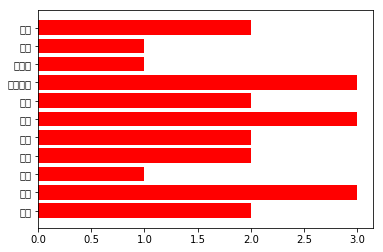

-------------하강-------------


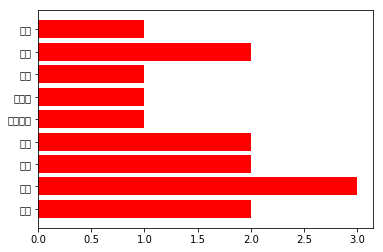

In [199]:
def draw_graph(freq_diction):
    import matplotlib.pyplot as plt
    count = freq_diction.values()
    word = freq_diction.keys()
    plt.barh(range(len(count)), count, color='red')
    plt.yticks(range(len(count)), word)
    plt.show()

print "-------------상승-------------"
draw_graph(frequency)
print "-------------하강-------------"
draw_graph(frequency2)